# Convolutional Autoencoders

A convolutional autoencoder (CAE) is a type of neural network often used in unsupervised learning, particularly well-suited for processing image data. They have various applications, such as image compression, denoising, and feature extraction.

Convolutional autoencoders consist of two main components &mdash; an encoder network and a decoder network:

* **The Encoder Network**: The encoder network compresses the input data into a low-dimensional representation using convolutional layers, which apply convolution operations to the input data using learnable filters or kernels. These layers generate feature maps, and by stacking multiple convolutional layers, they are able to capture spatial hierarchies of features within the input data. The encoder progressively reduces the spatial dimensions of the input data, capturing the most important features of the data and creating a compact, encoded representation at the bottleneck layer (a *bottleneck* refers to a layer or a set of layers in the network that have a smaller number of neurons compared to the layers before and after it).
  
* **The Decoder Network**: The decoder network reconstructs the original input data from the low-dimensional representation produced by the encoder. The decoder uses transposed convolutional layers (also refered to as deconvolutional layers) to progressively increase the spatial dimensions, reconstructing the original input data from the compressed form.

When training an autoencoder, there is a "fake" learning task and a "real" learning task:

* **The Real Learning Task**: The ultimate goal is to obtain a meaningful low-dimensional representation of the input data from the encoder. This is typically achieved through a bottleneck layer in the encoder, where the dimensions of the input data are significantly reduced. However, the network is not directly trained to accomplish this goal. Instead, this objective is achieved indirectly through a "fake learning task."

* **The Fake Learning Task**: Rather than training the network to directly learn a low-dimensional representation of the input data, the network is trained end-to-end to learn the identity function. That is to say, the input data should match the output data after passing through the encoder and decoder. This process ensures that the network can accurately reconstruct the input data. Additionally, by placing a bottleneck in the encoder, the network is forced to capture important features of the input data within the compressed representation. This bottleneck produces the desired low-dimensional representation required for the real learning task.

## An Example &mdash; The MNIST Dataset

To demonstrate the use of a convolutional autoencoder, consider the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), which contains images of handwritten digits. A convolutional autoencoder trained on this dataset can learn to compress each $28\times28$ pixel image into a low-dimensional representation using convolutional filters, and then reconstruct the original image from this compressed form.

# Imports

In [1]:
import gzip
import inspect
import logging
import os
import struct
import sys

import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection

import torch
import torch.nn
import torch.optim
import torch.utils.data

from IPython.display import clear_output, display

# Data Loading

The following variables specify the location and filenames required to read the MNIST dataset.

In [2]:
root = "../datasets"
dirname = "../datasets/MNIST/raw/"
train_x_basename = "train-images-idx3-ubyte.gz"
train_y_basename = "train-labels-idx1-ubyte.gz"
test_x_basename = "t10k-images-idx3-ubyte.gz"
test_y_basename = "t10k-labels-idx1-ubyte.gz"

## Data Loading Helper Functions

### `read_labels`

The `read_labels` function is used to read the target labels of the MNIST dataset from the file specified by `filename`.

In [3]:
def read_labels(filename):
    with gzip.open(filename, "rb") as fp:
        magic, size = struct.unpack(">II", fp.read(8))
        if magic != 2049:
            raise RuntimeError(f"Magic number mismatch, expected 2049, got {magic}")
        data = fp.read()
        return np.frombuffer(data, dtype=np.uint8).astype(int)

### `read_images`

The `read_labels` function is used to read the images of the MNIST dataset from the file specified by `filename`.

In [4]:
def read_images(filename):
    with gzip.open(filename, "rb") as fp:
        magic, size, rows, cols = struct.unpack(">IIII", fp.read(16))
        if magic != 2051:
            raise RuntimeError(f"Magic number mismatch, expected 2049, got {magic}")
        data = fp.read()
        return np.frombuffer(data, dtype=np.uint8).reshape((-1,28,28)).astype(float)

## Reading the Data

After loading the data, we can see that dataset contains 60,000 training examples and 10,000 validation examples. The labels are stored as integers, while the images are stored as doubles.

In [5]:
# # Uncomment the following lines to download the MNIST dataset
# import torchvision.datasets
# torchvision.datasets.MNIST(root=root, download=True, transform=None)

training_images = read_images( os.path.join(dirname, train_x_basename) )
training_labels = read_labels( os.path.join(dirname, train_y_basename) )
validation_images = read_images( os.path.join(dirname, test_x_basename) )
validation_labels = read_labels( os.path.join(dirname, test_y_basename) )

print(f"training_images:   {str(training_images.dtype) : >8} {training_images.shape}")
print(f"training_labels:   {str(training_labels.dtype) : >8} {training_labels.shape}")
print(f"validation_images: {str(validation_images.dtype) : >8} {validation_images.shape}")
print(f"validation_labels: {str(validation_labels.dtype) : >8} {validation_labels.shape}")

training_images:    float64 (60000, 28, 28)
training_labels:      int64 (60000,)
validation_images:  float64 (10000, 28, 28)
validation_labels:    int64 (10000,)


# Data Preprocessing

To effectively train an autoencoder, it essential to first preprocess the data. In this example, we'll rescale the pixel values in the images from the original range of $[0, 255]$ to a normalized range of $[0, 1]$. This normalization process to stabilize the training process and ensure consistent convergence.

In [6]:
training_images = training_images / 255.
validation_images = validation_images / 255.

## Data Visualization

Display a few example images to gain insight into their appearances.

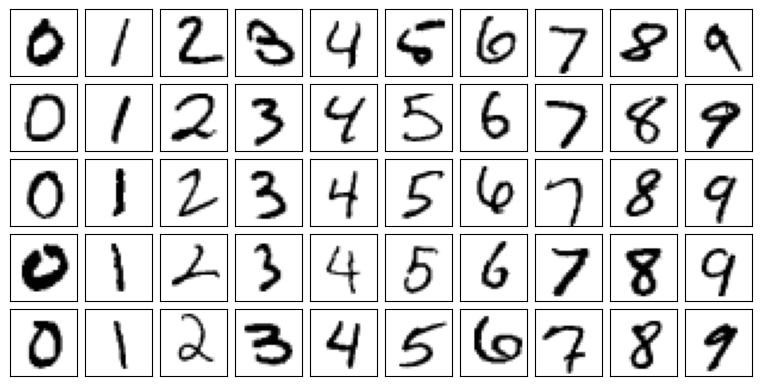

In [7]:
n_rows = 5
n_cols = 10

fig = plt.figure(constrained_layout=True, figsize=(0.75*n_cols,0.75*n_rows))
gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, figure=fig)
for col in range(10):
    samples = validation_images[validation_labels == col]
    for row in range(n_rows):
        ax = fig.add_subplot(gs[row,col])
        ax.imshow(samples[row], cmap="binary", vmin=0., vmax=1.)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

## Digit Distribution

Generate histograms to visualize the distribution of the digits in the dataset. After analyzing these plots, it's clear that there is no data imbalance in the distribution of the target labels (digits).

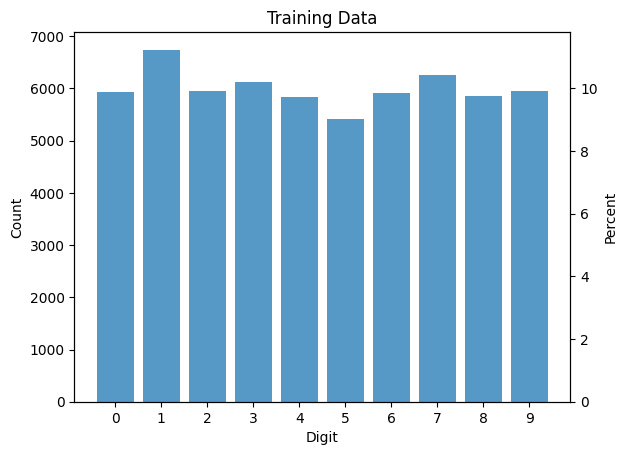

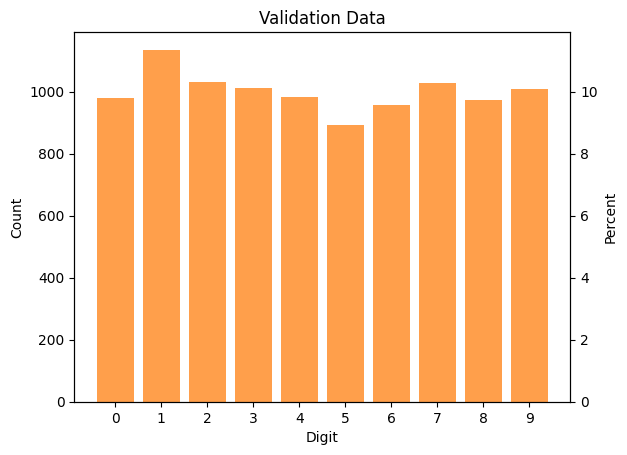

In [8]:
training_digits, training_counts = np.unique(training_labels, return_counts=True)
validation_digits, validation_counts = np.unique(validation_labels, return_counts=True)

colors =  plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig,ax = plt.subplots()
ax.bar(training_digits, training_counts, color=colors[0], alpha=0.75)
ax.xaxis.set_ticks(training_digits)
ax.set_title("Training Data")
ax.set_ylabel("Count")
ax.set_xlabel("Digit")
ax = ax.twinx()
ax.bar(training_digits, training_counts/training_counts.sum() * 100, alpha=0)
ax.set_ylabel("Percent")
plt.show()

fig,ax = plt.subplots()
ax.bar(validation_digits, validation_counts, color=colors[1], alpha=0.75)
ax.xaxis.set_ticks(validation_digits)
ax.set_title("Validation Data")
ax.set_ylabel("Count")
ax.set_xlabel("Digit")
ax = ax.twinx()
ax.bar(validation_digits, validation_counts/validation_counts.sum() * 100, alpha=0)
ax.set_ylabel("Percent")
plt.show()

# The Model (CAE)

Our convolutional autoencoder consists of a fairly involved encoder and decoder:

* **Encoder**: The encoder begins with two convolutional layers ([torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) with leaky ReLU activations ([torch.nn.LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)). The resulting feature maps are flattened into a 1D vector ([torch.nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)) and passed through a dropout layer ([torch.nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)). Next, three fully connected layers ([torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) with leaky ReLU activations progressively reduce the dimensionality of the feature maps until they reach a latent space of 10 dimensions.

* **Decoder**: The decoder starts by expanding the 10-dimensional latent space into a higher-dimensional space using three fully connected layers with leaky ReLU activations. The resulting 1D vector is then reshaped into the appropriate dimensions for convolutional processing using an unflattening layer ([torch.nn.Unflatten](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html)) before being passed to a dropout layer. Two transposed convolutional layers ([torch.nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)) with leaky ReLU activations then upsample the feature maps back to the original input dimensions. The final result is passed through sigmoid activation ([torch.nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)).

In [9]:
class CAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_ = torch.nn.Sequential(
            torch.nn.Unflatten(dim=1, unflattened_size=(1,28)),
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Flatten(start_dim=1, end_dim=-1),
            torch.nn.Dropout(),
            torch.nn.Linear(in_features=5184, out_features=2**10),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(in_features=2**10, out_features=2**6),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(in_features=2**6, out_features=10),
        )
        self.decoder_ = torch.nn.Sequential(
            torch.nn.Linear(in_features=10, out_features=2**6),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(in_features=2**6, out_features=2**10),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(in_features=2**10, out_features=5184),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Unflatten(dim=1, unflattened_size=(16,18,18)),
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=5),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=7),
            torch.nn.Sigmoid(),
            torch.nn.Flatten(start_dim=1, end_dim=2)
        )

    def encode(self, X):
        return self.encoder_(X)

    def decode(self, X):
        return self.decoder_(X)

    def forward(self, X):
        return self.decode( self.encode(X) )

# Callback Handlers

The following sections define callback handlers to monitor the training progress of the neural network. While the details of these handlers are not particularly important, they play a crucial role in tracking and plotting various aspects of the training process.

## CalculatePerformance

The `CalculatePerformance` callback handler is used to compute and log the network's performance between epochs and mini-batches.

In [10]:
class CalculatePerformance():
    def __init__(
        self,
        criterion,
        training_dataloader=None,
        validation_dataloader=None,
        device="cpu",
        warm_start=False
    ):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self.training_loss = list()
        self.validation_loss = list()
        self.mini_batch_loss = list()

    @torch.no_grad()
    def _get_performance(self, model, dataloader):
        n_samples = 0
        loss = torch.tensor(0., dtype=torch.float32).to(self.device)
        model.to(self.device).eval()
        for x_train,y_train in dataloader:
            n_samples += len(x_train)
            x_train, y_train = x_train.to(self.device), y_train.to(self.device)
            y_pred = model(x_train)
            loss += self.criterion(y_pred, y_train) * len(x_train) if self.criterion.reduction=="mean" else 1
        if self.criterion.reduction == "mean":
            loss /= n_samples
        return loss.item()

    def _calculate_training_performance(self, model):
        loss = self._get_performance(model,self.training_dataloader)
        self.training_loss.append(loss)

    def _calculate_validation_performance(self, model):
        loss = self._get_performance(model,self.validation_dataloader)
        self.validation_loss.append(loss)

    def _calculate_performance(self, model, logs):
        if self.training_dataloader is not None:
            self._calculate_training_performance(model)
            logs["training_loss"] = np.asarray(self.training_loss)
        if self.validation_dataloader is not None:
            self._calculate_validation_performance(model)
            logs["validation_loss"] = np.asarray(self.validation_loss)

    def on_training_start(self, n_epochs, model, logs):
        if not self.warm_start:
            self.training_loss = list()
            self.validation_loss = list()
            self.mini_batch_loss = list()
        self._calculate_performance(model, logs)

    def on_mini_batch_end(self, epoch, mini_batch, n_batches, batch_size, loss, model, logs):
        while len(self.mini_batch_loss) < epoch:
            self.mini_batch_loss.append(list())
        self.mini_batch_loss[-1].append(loss)
        logs["mini_batch_loss"] = np.asarray(self.mini_batch_loss[-1])

    def on_epoch_end(self, epoch, model, logs):
        self._calculate_performance(model, logs)

## PrintProgress

The `PrintProgress` callback handler prints the performance of the network between epochs and mini-batches. The level of detail is controlled using the `verbose` parameter. It's important to note that the `CalculatePerformance` handler needs to have been invoked prior to invoking this handler.

In [11]:
# 1 final score
# 2 every 10th score
# 3 every 10th score + mini batch summary
# 4 every 10th score + mini batch mini details
# 5 every 10th score + mini batch all details
# 6 every score
# 7 every score + mini batch summary
# 8 every score + mini batch mini details
# 9 every score + mini batch all details

class PrintProgress():
    def __init__(self, verbose=0, verbose_epoch_mod=10, verbose_mini_batch_mod=10):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self.logger = logging.getLogger("PrintProgress")
        if not self.logger.hasHandlers():
            self.logger.addHandler( logging.StreamHandler(sys.stdout) )
        self.logger.setLevel(logging.DEBUG-verbose)

    def _log_epoch_progress_helper(self, epoch, n_epochs, logs, message_level):
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        # training performance
        training_loss = logs.get("training_loss", [np.nan])[-1]
        # validation performance
        validation_loss = logs.get("validation_loss", [np.nan])[-1]
        # message
        message = (
            f"Epoch: {epoch:>{n_epochs_digits}d}/{n_epochs} ({epoch/n_epochs*100:6.2f}%)   "
            f"Training Loss: {training_loss:.6f}   Validation Loss: {validation_loss:.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_epoch_progress(self, epoch, n_epochs, logs):
        if epoch == n_epochs:
            message_level = 1
        elif epoch == 0 or epoch % self.verbose_epoch_mod == 0:
            message_level = 2
        else:
            message_level = 6
        self._log_epoch_progress_helper(epoch, n_epochs, logs, message_level)

    def _log_mini_batch_progress_helper(self, epoch, n_epochs, mini_batch, n_batches, batch_size, loss, message_level):
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        n_mini_batch_digits = int(np.log10(n_batches)) + 1
        message = (
            f"Epoch: {epoch:<{n_epochs_digits}d}  "
            f"[{mini_batch:>{n_mini_batch_digits}d}/{n_batches}  ({mini_batch/n_batches*100:3.0f}%)]   "
            f"Loss: {loss:15.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_mini_batch_summary(self, epoch, n_epochs, logs, message_level):
        mini_batch_loss = logs["mini_batch_loss"]
        mean, std = np.mean(mini_batch_loss), np.std(mini_batch_loss)
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        message = (
            f"Epoch: {epoch:<{n_epochs_digits}d}   "
            f"Mini Batch Average Loss: {mean:.6f} +/- {std:.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_mini_batch_progress(self, epoch, n_epochs, mini_batch, n_batches, batch_size, loss, logs):
        if epoch == n_epochs or epoch % self.verbose_epoch_mod == 0:
            message_level = 4 if mini_batch % self.verbose_mini_batch_mod == 0 or mini_batch == n_batches else 5
            message_level += 4 if self.verbose >= 6 else 0
        elif mini_batch % self.verbose_mini_batch_mod == 0 or mini_batch == n_batches:
            message_level = 8
        else:
            message_level = 9
        self._log_mini_batch_progress_helper(epoch, n_epochs, mini_batch, n_batches, batch_size, loss, message_level)
        if mini_batch == n_batches:
            if epoch % self.verbose_epoch_mod == 0 or epoch == n_epochs:
                message_level = 3
                message_level += 4 if self.verbose >= 6 else 0
            else:
                message_level = 7
            self._log_mini_batch_summary(epoch, n_epochs, logs, message_level)

    def on_training_start(self, n_epochs, model, logs):
        self.n_epochs = n_epochs
        self._log_epoch_progress(0, self.n_epochs, logs)

    def on_mini_batch_end(self, epoch, mini_batch, n_batches, batch_size, loss, model, logs):
        self._log_mini_batch_progress(epoch, self.n_epochs, mini_batch, n_batches, batch_size, loss, logs)

    def on_epoch_end(self, epoch, model, logs):
        self._log_epoch_progress(epoch, self.n_epochs, logs)

## PlotProgress

The `PlotProgress` callback handler serves to visualize the loss and accuracy of the network across epochs and mini-batches. Additionally, it generates plots displaying sample digits and their predictions. Note that this handler requires the invocation of the `CalculateLoss` handler to ensure accurate data for plotting.

In [12]:
class PlotProgress():
    def __init__(self, plotting_samples, limit_loss, device):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)

    def _plot_loss(self, ax, training_loss, validation_loss, limit):
        epochs = None
        if training_loss is not None:
            epochs = np.arange(len(training_loss))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], training_loss[-limit:], marker=marker, label="Traning Loss")
        if validation_loss is not None:
            epochs = epochs if epochs is not None else np.arange(len(validation_loss))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], validation_loss[-limit:], marker=marker, label="Validation Loss")
        if epochs is not None:
            ax.set_xlabel("Epoch")
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_ylabel("MSE Loss")
            ax.legend()

    def _plot_accuracy(self, ax, training_accuracy, validation_accuracy, limit):
        epochs = None
        if training_accuracy is not None:
            epochs = np.arange(len(training_accuracy))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], training_accuracy[-limit:], marker=marker, label="Traning Accuracy")
        if validation_accuracy is not None:
            epochs = epochs if epochs is not None else np.arange(len(validation_accuracy))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], validation_accuracy[-limit:], marker=marker, label="Validation Accuracy")
        if epochs is not None:
            ax.set_xlabel("Epoch")
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_ylabel("Accuracy")
            ax.legend()

    def _plot_samples(self, fig, gs, samples):
        for ii,sample in enumerate(samples):
            ax = fig.add_subplot(gs[ii])
            ax.imshow(sample, cmap="binary", vmin=0., vmax=1.)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    def _get_grid_size(self, count):
        n_cols = 5
        n_rows = int(np.ceil(count/n_cols))
        return n_rows, n_cols

    @torch.no_grad()
    def _plot_results(self, epoch, training_loss, validation_loss, training_accuracy, validation_accuracy, model):
        if epoch % 10 == 0:
            model.to(self.device).eval()
            outputs = model(
                torch.from_numpy(self.plotting_samples.astype(np.float32)).to(self.device)
            ).to("cpu").numpy()

            clear_output(wait=True)
            n_rows, n_cols = 3, 2
            fig = plt.figure(figsize=(n_cols*6.4, n_rows*4.8))
            gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, figure=fig)
            self._plot_loss(fig.add_subplot(gs[0,0]), training_loss, validation_loss, -1)
            self._plot_loss(fig.add_subplot(gs[0,1]), training_loss, validation_loss, self.limit_loss)
            self._plot_samples(fig, gs[1:,0].subgridspec(*self._get_grid_size(len(self.plotting_samples))), self.plotting_samples)
            self._plot_samples(fig, gs[1:,1].subgridspec(*self._get_grid_size(len(self.plotting_samples))), outputs)
            fig.suptitle(f"Iteration {epoch}", x=(fig.subplotpars.right + fig.subplotpars.left)/2, y=1.001)
            fig.tight_layout()
            plt.show()

    def on_training_start(self, n_epochs, model, logs):
        self._plot_results(
            0,
            logs.get("training_loss", None),
            logs.get("validation_loss", None),
            logs.get("training_accuracy", None),
            logs.get("validation_accuracy", None),
            model
        )

    def on_mini_batch_end(self, epoch, mini_batch, n_batches, batch_size, loss, model, logs):
        return

    def on_epoch_end(self, epoch, model, logs):
        self._plot_results(
            epoch,
            logs.get("training_loss", None),
            logs.get("validation_loss", None),
            logs.get("training_accuracy", None),
            logs.get("validation_accuracy", None),
            model
        )

# Traning

## Training Loop

The `train_model` function implements a standard training loop for a neural network with callbacks. The training loop allows for the integration of various callback handlers while training the neural network model and facilitates monitoring and logging of training progress.

More specifically, a dictionary, `logs`, is used to store training logs generated by callback handlers, and the `on_training_start` method is invoked on each handler. Then, the code performs `n_epochs` iterations of the following:
  - On each epoch, the training data is split into mini-batches using `dataloader`.
  - For each mini-batch, the loop performs forward and backward passes through `model`, using `criterion` to compute the loss, and `optimizer` to update the model parameters.
  - After each mini-batch, registered callbacks are notified by calling `on_mini_batch_end` on each callback handler.
  - At the end of each epoch, the registered callback handlers are notified using the `on_epoch_end` callback method.

In [13]:
def time_function(msg="Elapsed Time:"):
    import time
    from datetime import timedelta
    def real_timing_function(function):
        def wrapper(*args, **kwargs):
            start_time = time.time()
            res = function(*args, **kwargs)
            elapsed = time.time() - start_time
            print(msg, timedelta(seconds=elapsed))
            return res
        return wrapper
    return real_timing_function

@time_function("Training Time:")
def train_model(
    model,
    device,
    dataloader,
    criterion,
    optimizer,
    n_epochs,
    callbacks=None,
    logs=None
):
    if callbacks is None:
        callbacks = list()
    if logs is None:
        logs = dict()
    
    # notify each callback of the beginning of training
    for callback in callbacks:
        model.to(device).eval()
        callback.on_training_start(n_epochs, model, logs)
    
    for epoch in range(1,n_epochs+1):
        for mini_batch,(x_train,y_train) in enumerate(dataloader, 1):
            # zero out the generator gradients
            optimizer.zero_grad()
            model.to(device).train()

            # pass the data through the model and compute the loss
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)

            # compute the gradients and update the model's weights
            loss.backward()
            optimizer.step()
    
            # notify each callback of the mini batch
            for callback in callbacks:
                model.to(device).eval()
                callback.on_mini_batch_end(
                    epoch, mini_batch, len(dataloader), len(x_train), loss.item(), model, logs
                )
        
        # notify each callback of the end of epoch
        for callback in callbacks:
            model.to(device).eval()
            callback.on_epoch_end(epoch, model, logs)

## Parameters

The following variables control the training loop:
- `n_epochs` &mdash; specifies the number of training epochs
- `batch_size` &mdash; determines the number of samples used in each mini-batch
- `shuffle` &mdash; when set to `True`, the data is reshuffled at the beginning of every epoch
- `device` &mdash; specifies whether calculations are performed on the GPU (set to `'cuda'`) or the CPU (set to `'cpu'`)

The model, `cae`, is also initialized here as it is needed later when the optimizer is defined.

In [14]:
n_epochs = 50
batch_size = 256
shuffle = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cae = CAE()

print(device)
print(cae)

cuda
CAE(
  (encoder_): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(1, 28))
    (1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=5184, out_features=1024, bias=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): Linear(in_features=1024, out_features=64, bias=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder_): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=64, out_features=1024, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=1024, out_features=518

## Loss Function

In the case of the MNIST dataset, it is common to choose [mean squared error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) as the loss function, which is implemented using [torch.nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html).

In [15]:
mse_loss = torch.nn.MSELoss(reduction="mean")

## Optimizer

Here, we define our optimizer, a modified version of gradient descent called AdamW ([torch.optim.AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)). AdamW is an extension of Adam that addresses the weight decay issue in Adam. By setting weight_decay=0.01, we are employing weight decay regularization to try to prevent overfitting.

In [16]:
adam_optimizer = torch.optim.AdamW(cae.parameters(), weight_decay=0.01)

## Data Loaders

For ease of training, our dataset will be loaded into a [torch.utils.data.TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) and accessed using a [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

### Training DataLoader

In [17]:
training_tensor = torch.from_numpy(training_images.astype(np.float32))
training_dataset = torch.utils.data.TensorDataset(training_tensor, training_tensor)
training_dataloader = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
)

### Validation DataLoader

In [18]:
validation_tensor = torch.from_numpy(validation_images.astype(np.float32))
validation_dataset = torch.utils.data.TensorDataset(validation_tensor, validation_tensor)
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False
)

## Initialize Callbacks

Here we initialize the callback objects and add them to the `callbacks` list. To reduce the computation required to log the training and validation loss between each epoch, a subset of size $500=50\cdot10$ from their respective datasets is utilize.

In [19]:
n_samples = 50
training_idx = np.concatenate([
    np.where(training_labels == ii)[0][:n_samples]
    for ii in range(10)
])
validation_idx = np.concatenate([
    np.where(validation_labels == ii)[0][:n_samples]
    for ii in range(10)
])
training_tensor = torch.from_numpy(training_images[training_idx].astype(np.float32))
validation_tensor = torch.from_numpy(validation_images[validation_idx].astype(np.float32))
calculate_performance = CalculatePerformance(
    criterion=mse_loss,
    training_dataloader=torch.utils.data.DataLoader(
        dataset=torch.utils.data.TensorDataset(training_tensor, training_tensor),
        batch_size=500
    ),
    validation_dataloader=torch.utils.data.DataLoader(
        dataset=torch.utils.data.TensorDataset(validation_tensor, validation_tensor),
        batch_size=500
    ),
    device=device
)

print_progress = PrintProgress(
    verbose=6
)

n_samples = 5
idx = np.concatenate([
    np.where(validation_labels == ii)[0][:n_samples]
    for ii in range(10)
])
plotting_samples = validation_images[idx]
plot_progress = PlotProgress(
    plotting_samples=plotting_samples,
    limit_loss=10,
    device=device
)

callbacks = [calculate_performance, print_progress, plot_progress]

## Train the Model

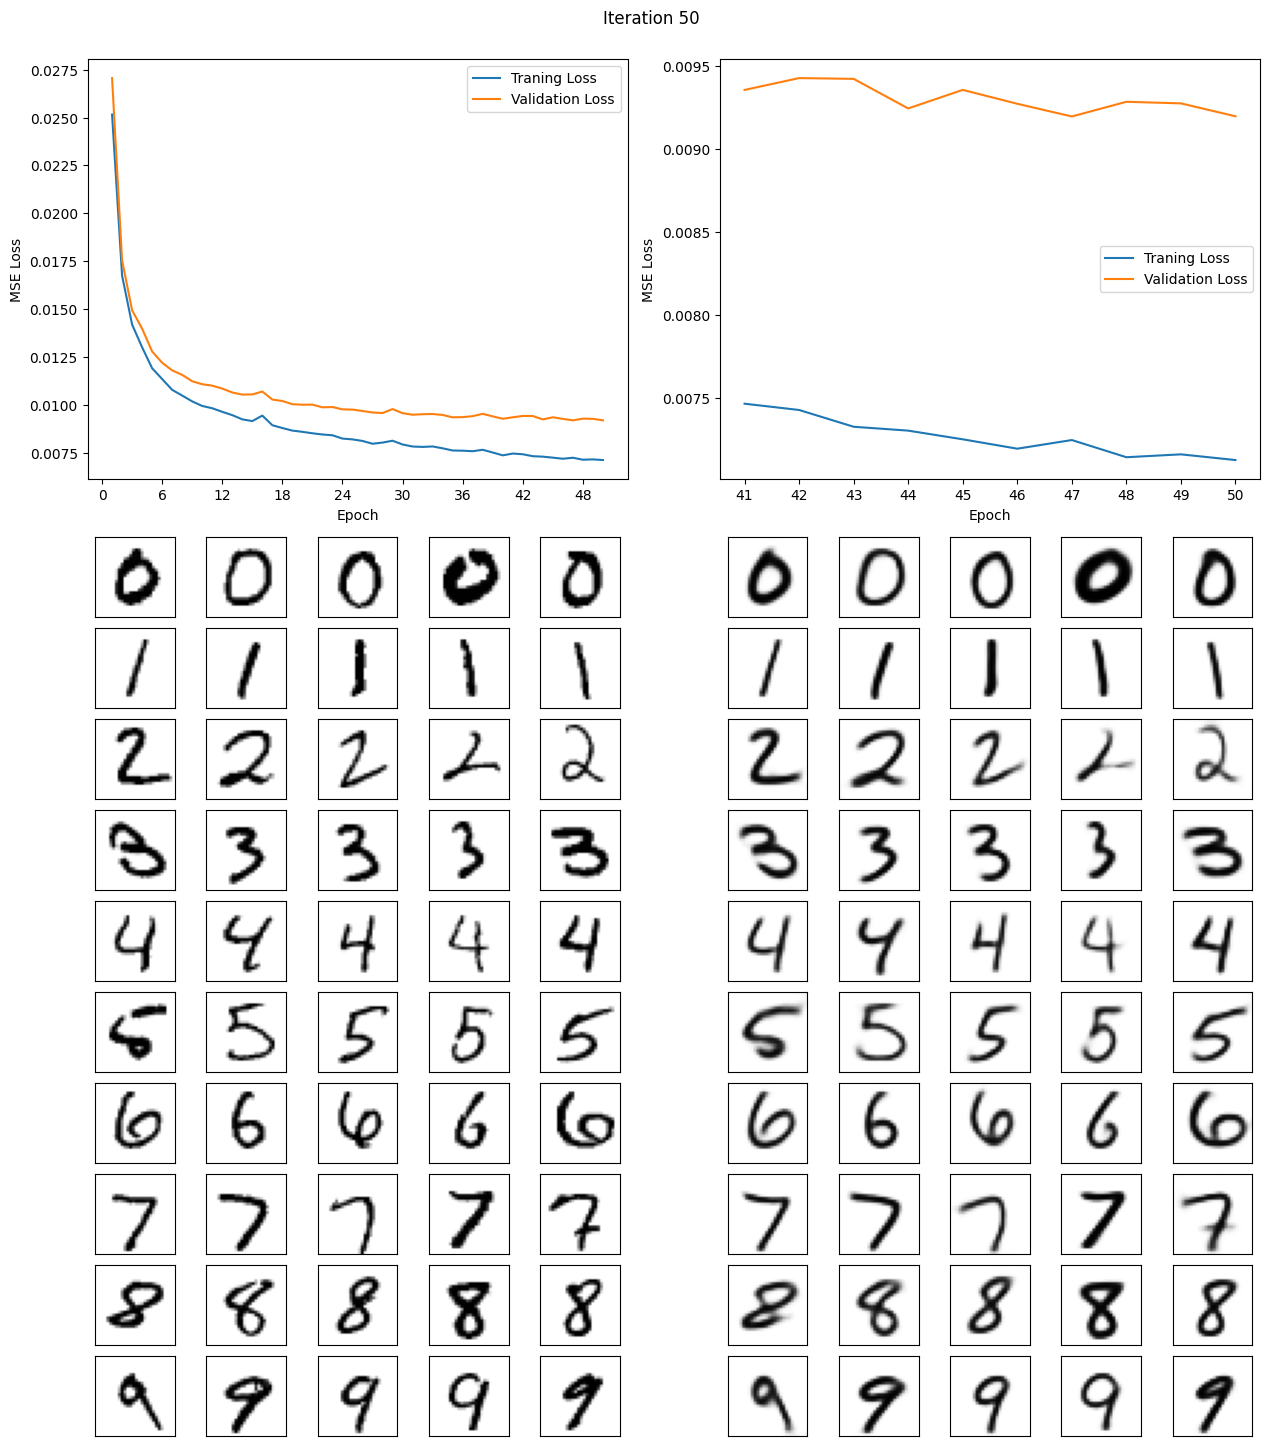

Training Time: 0:03:56.100137


In [20]:
logs = dict()
train_model(
    model=cae,
    device=device,
    dataloader=training_dataloader,
    criterion=mse_loss,
    optimizer=adam_optimizer,
    n_epochs=n_epochs,
    callbacks=callbacks,
    logs=logs
)

# Performance Evaluation

Despite the use of dropout layers and weight decay regularization as part of the AdamW optimizer, our CAE still appears to be overfitting on the training data. However, it is worth noting that performance on the validation dataset remains very good. The following section examines the reconstruction error of the trained convolutional autoencoder.

## Performance Evaluation Helper Functions

### `calculate_reconstruction_error`

The following function computes the reconstruction error of `model` on `images` under MSE loss.

In [21]:
@torch.no_grad()
def compute_reconstruction_error(images, model, device):
    images = images.astype(np.float32)
    model.to(device).eval()
    outputs = model( torch.from_numpy(images).to(device) ).cpu().numpy()
    return np.square(outputs - images).reshape(len(images),-1).mean(axis=1)

### `compute_mse_summary_statistics_by_digit`

The following function divides `images` by digit using `labels` and calculates the MSE loss for each sample reconstructed by `model`. It then computes summary statistics of the per digit MSE loss values and it returns these statistics in a Pandas dataframe.

In [22]:
def compute_mse_summary_statistics_by_digit(images, labels, model, device):
    mse = compute_reconstruction_error(images, model, device)
    dfs = [
        pd.DataFrame(mse[labels==ii], columns=[ii]).describe()
        for ii in range(10)
    ] + [pd.DataFrame(mse, columns=["Overall"]).describe()]
    return mse, pd.concat(dfs, axis=1).transpose()

## Reconstruction Error

By examining the per-digit reconstruction error, we can see that our autoencoder has the least difficulty reconstructing 1's, while 8's followed by 2's 3's and 5's present the most challenges.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 10.88 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv_transpose2d(


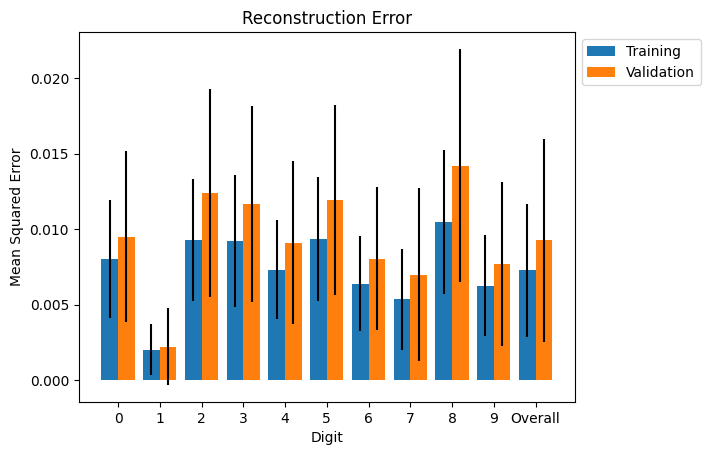

,count,mean,std,min,25%,50%,75%,max
Training,,,,,,,,
0,5923.0,0.008016,0.003895,0.001832,0.005345,0.007082,0.009690,0.042661
1,6742.0,0.002009,0.001683,0.000392,0.001124,0.001533,0.002244,0.027849
2,5958.0,0.009304,0.004045,0.002108,0.006529,0.008433,0.011014,0.052527
3,6131.0,0.009226,0.004383,0.002009,0.006247,0.008309,0.011043,0.040197
4,5842.0,0.007301,0.003291,0.001917,0.005006,0.006599,0.008766,0.033319
5,5421.0,0.009352,0.004129,0.002185,0.006485,0.008553,0.011229,0.041667
6,5918.0,0.006381,0.003154,0.001621,0.004200,0.005600,0.007759,0.032377
7,6265.0,0.005350,0.003339,0.000930,0.003137,0.004419,0.006560,0.046380
8,5851.0,0.010475,0.004770,0.002723,0.007141,0.009556,0.012665,0.044137


,count,mean,std,min,25%,50%,75%,max
Validation,,,,,,,,
0,980.0,0.009484,0.005678,0.002341,0.005952,0.008215,0.011298,0.069581
1,1135.0,0.002208,0.002540,0.000336,0.001164,0.001605,0.002362,0.034283
2,1032.0,0.012392,0.006889,0.003083,0.007831,0.010665,0.014778,0.054991
3,1010.0,0.011668,0.006468,0.001931,0.007546,0.010199,0.013677,0.062821
4,982.0,0.009109,0.005391,0.002176,0.005649,0.007785,0.010745,0.047709
5,892.0,0.011939,0.006292,0.003288,0.007808,0.010363,0.014412,0.048856
6,958.0,0.008050,0.004771,0.002066,0.004836,0.006925,0.009820,0.043927
7,1028.0,0.006973,0.005723,0.001233,0.003245,0.005205,0.008306,0.049559
8,974.0,0.014212,0.007736,0.003339,0.008778,0.012204,0.017402,0.060219


In [23]:
training_mse, training_df = compute_mse_summary_statistics_by_digit(training_images, training_labels, cae, device)
validation_mse, validation_df = compute_mse_summary_statistics_by_digit(validation_images, validation_labels, cae, device)
training_df.index.name = "Training"
validation_df.index.name = "Validation"

width = 0.4
xx = np.arange(len(validation_df.index))
fig,ax = plt.subplots()
ax.bar(xx - width/2, training_df["mean"], width=width, label="Training")
plt.errorbar(xx - width/2, training_df["mean"], training_df["std"], color="black", linestyle="")
ax.bar(xx + width/2, validation_df["mean"], width=width, label="Validation")
plt.errorbar(xx + width/2, validation_df["mean"], validation_df["std"], color="black", linestyle="")
ax.xaxis.set_ticks(xx)
ax.xaxis.set_ticklabels(validation_df.index)
ax.set_xlabel("Digit")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Reconstruction Error")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

display(training_df, validation_df)

# Visual Evaluation

For a visual evaluation of our autoencoder, we can look at digits with the best and worst reconstruction errors.

### `plot_image`

The following function plots a single image using the specified colormap on the given axis. If `ax` is `None`, a new figure is created and displayed.

In [24]:
def plot_image(image, cmap="binary", ax=None):
    ax_is_none = ax is None
    if ax_is_none:
        fig,ax = plt.subplots(figsize=(0.75,0.75))
    ax.imshow(image, cmap=cmap, vmin=0., vmax=1.)
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if ax_is_none:
        plt.show()

### `plot_images`

The following function plots each image in `images` using the gridspec `gs` on `fig`. It is assumed that the gridspec is large enough to accommodate all the images.

In [25]:
def plot_images(images, fig, gs):
    for ii,image in enumerate(images):
        plot_image(image, ax=fig.add_subplot(gs[ii]))

### `plot_best_reconstructed_images`

The following function identifies the images with the smallest reconstruction error and plots them.
- `images` &mdash; the collection of images
- `labels` &mdash; used to determine the class of each image in `images`
- `mse` &mdash; the mse reconstruction error for the images
- `n_samples` &mdash; the number of samples of each digit to plot
- `model` &mdash; the model used to reconstruct the images
- `device` &mdash; the computing device to run the model on
- `title` &mdash; the title for the plot

In [26]:
@torch.no_grad()
def plot_best_reconstructed_images(images, labels, mse, n_samples, model, device, title):
    images = images.astype(np.float32)
    tmp_idx = np.argsort(mse)
    sample_images = np.concatenate([
        images[tmp_idx][
            np.where(labels[tmp_idx] == ii)[0][:n_samples]
        ]
        for ii in range(10)
    ])

    model.to(device).eval()
    reconstructed_images = model( torch.from_numpy(sample_images).to(device) ).cpu().numpy()

    n_rows = 10
    n_cols = n_samples
    fig = plt.figure(figsize=(2*0.75*n_cols,0.75*n_rows))
    gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, wspace=0.05, figure=fig)
    plot_images(sample_images, fig, gs[0,0].subgridspec(n_rows, n_cols, wspace=0, hspace=0))
    plot_images(reconstructed_images, fig, gs[0,1].subgridspec(n_rows, n_cols, wspace=0, hspace=0))
    fig.suptitle(title, y=0.95)
    plt.show()

## Reconstructed Images

The following plots display some of the best, worst, and average images for each of the 10 digits, based on their reconstruction error. The images in the grid on the left are the original MNIST images, while the images in the grid on the right are the reconstructed versions generated by the autoencoder.

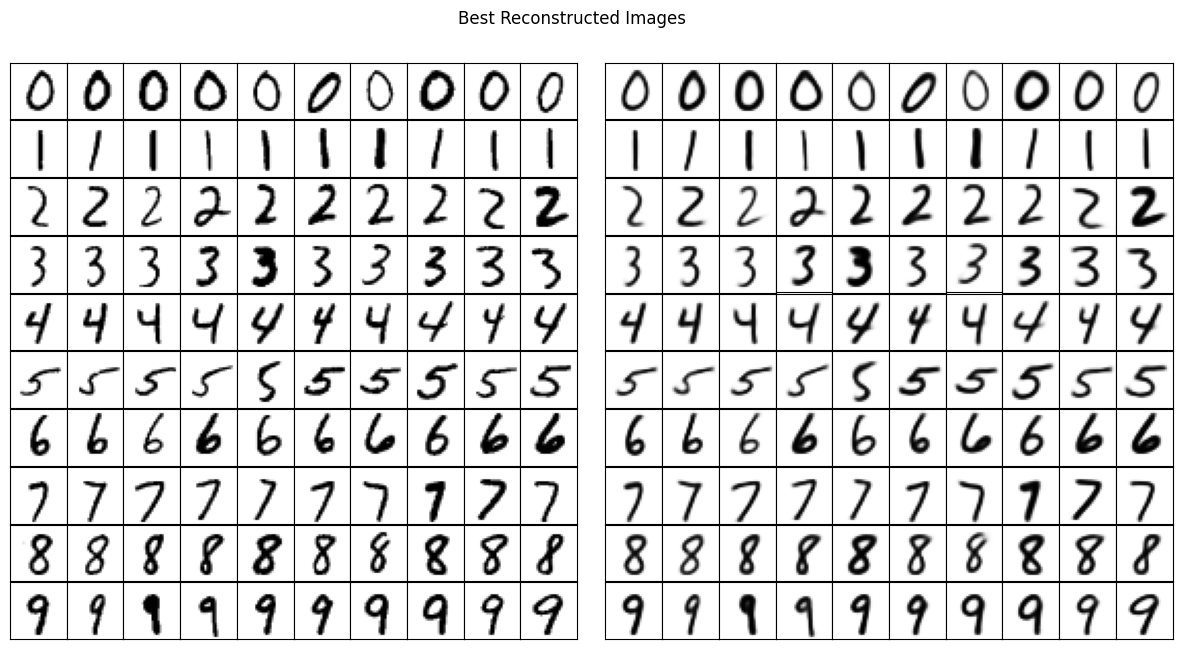

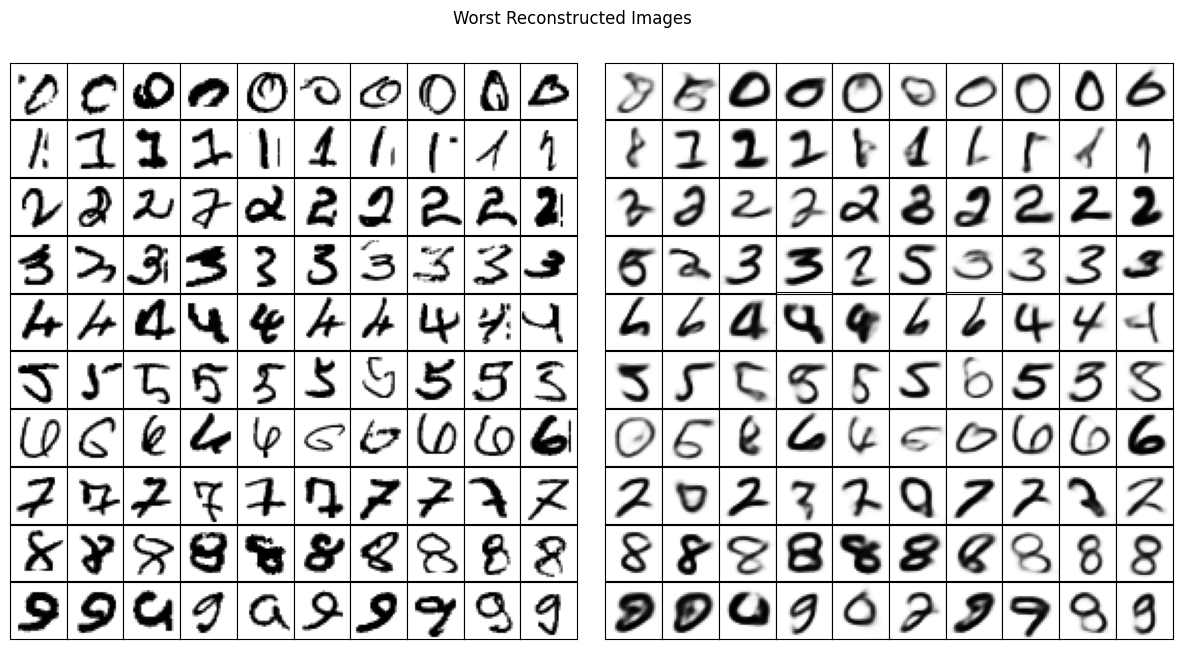

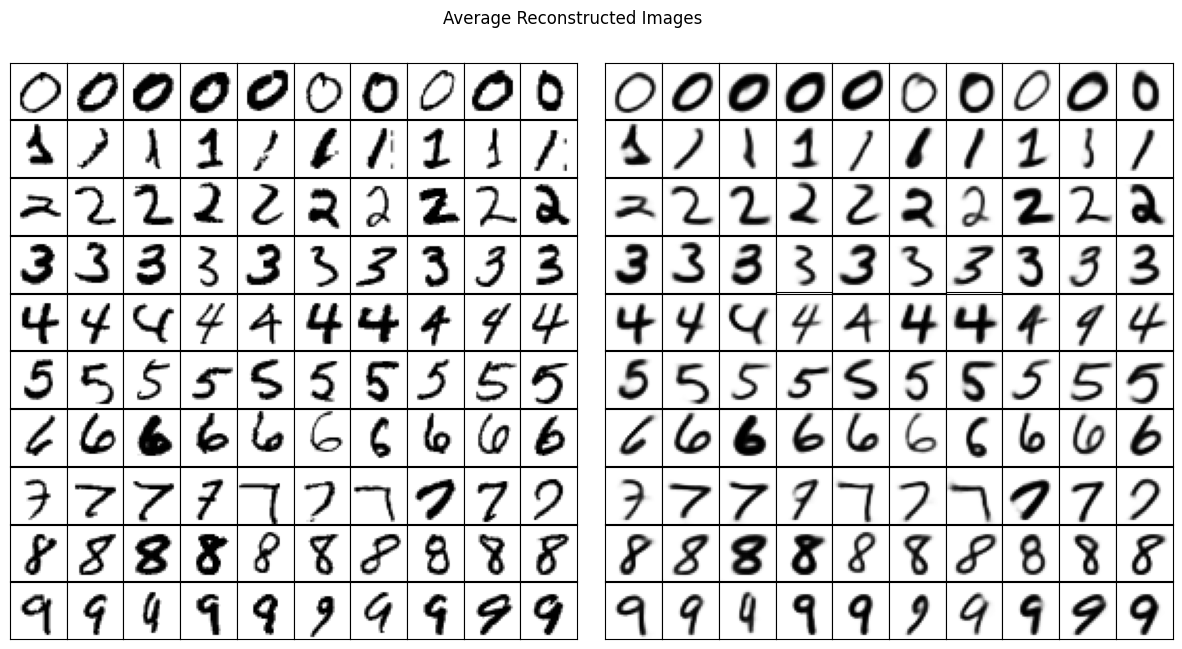

In [27]:
plot_best_reconstructed_images(
    images=validation_images,
    labels=validation_labels,
    mse=validation_mse,
    n_samples=10,
    model=cae,
    device=device,
    title="Best Reconstructed Images"
)

# multiply mse by -1 to plot the worset reconstructed images
plot_best_reconstructed_images(
    images=validation_images,
    labels=validation_labels,
    mse=-1*validation_mse,
    n_samples=10,
    model=cae,
    device=device,
    title="Worst Reconstructed Images"
)

# take the distance from the mean to plot the average reconstructed images
plot_best_reconstructed_images(
    images=validation_images,
    labels=validation_labels,
    mse=np.abs(validation_mse - validation_mse.mean()),
    n_samples=10,
    model=cae,
    device=device,
    title="Average Reconstructed Images"
)